1. We will use an encoder (either a CNN or an RNN) to map each string of text (hypothesis and premise) to a fixed-dimension vector representation.
2. We will interact the two hidden representations and output a 3-class soft- max. (To keep things simple, we will simply concatenate the two repre- sentations, and feed them through a network of 2 fully-connected layers.)

<h2>CNN</h2>
For the CNN, a 2-layer 1-D convolutional network with ReLU activations will suffice. We can perform a max-pool at the end to compress the hidden representation into a single vector.

<h2>RNN</h2>
For the RNN, a single-layer, bi-directional GRU will suffice. We can take the last hidden state as the encoder output. (In the case of bi-directional, the last of each direction, although PyTorch takes care of this.)

Perform tuning over at least <b>two</b> of the following hyperparameters:
<br>• Varying the size of the hidden dimension of the CNN and RNN
<br>• Varying the kernel size of the CNN
<br>• Experiment with different ways of interacting the two encoded sentences
(concatenation, element-wise multiplication, etc)
<br>• Regularization (e.g. weight decay, dropout)

In [43]:
import torch
import torchtext
import numpy as np
import copy
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
target_to_index = {'neutral':0, 'entailment':1, 'contradiction':2}
index_to_target = ['neutral', 'entailment', 'contradiction']
TEXT = torchtext.data.ReversibleField(lower=True, include_lengths=True, batch_first=True)
LABEL = torchtext.data.ReversibleField(sequential=False, use_vocab=False, preprocessing = lambda x : target_to_index[x])
GENRE = torchtext.data.ReversibleField(sequential=False, use_vocab=True)

In [3]:
snli_train_path = '../hw2_data/snli_train.tsv'
snli_train_examples = torchtext.data.TabularDataset(snli_train_path,format='tsv', skip_header = True,
                                                   fields=[('text_1',TEXT),('text_2',TEXT),
                                                           ('label',LABEL)])
snli_val_path = '../hw2_data/snli_val.tsv'
snli_val_examples = torchtext.data.TabularDataset(snli_val_path,format='tsv', skip_header = True,
                                                   fields=[('text_1',TEXT),('text_2',TEXT),
                                                           ('label',LABEL)])
mnli_train_path = '../hw2_data/mnli_train.tsv'
mnli_train_examples = torchtext.data.TabularDataset(mnli_train_path,format='tsv', skip_header = True,
                                                   fields=[('text_1',TEXT),('text_2',TEXT),
                                                           ('label',LABEL), ('genre',GENRE)])
mnli_val_path = '../hw2_data/mnli_val.tsv'
mnli_val_examples = torchtext.data.TabularDataset(mnli_val_path,format='tsv', skip_header = True,
                                                   fields=[('text_1',TEXT),('text_2',TEXT),
                                                           ('label',LABEL),('genre',GENRE)])

In [4]:
Vectors = torchtext.vocab.Vectors(name='../hw2_data/wiki-news-300d-1M.vec')
TEXT.build_vocab(snli_train_examples,snli_val_examples,mnli_train_examples,mnli_val_examples, vectors= Vectors)
GENRE.build_vocab(mnli_train_examples)

In [5]:
snli_train_iter = torchtext.data.BucketIterator(snli_train_examples, batch_size=128, sort_key= lambda e: len(e.text_1) + len(e.text_2),
                             repeat=False, shuffle=True, device=0)
snli_val_iter = torchtext.data.BucketIterator(snli_val_examples, batch_size=128, sort_key= lambda e: len(e.text_1) + len(e.text_2),
                             repeat=False, shuffle=True, device=0)


In [6]:
class Rnn(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, vocab, is_separate=False):
        
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vocab = vocab
        self.embedding = torch.nn.Embedding(self.vocab.vectors.shape[0],vocab.vectors.shape[1])
        self.embedding.weight = torch.nn.Parameter(self.vocab.vectors, requires_grad=False)
        self.gru_1 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        if is_separate:
            self.gru_2 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        else:
            self.gru_2 = self.gru_1
            
        
        h_0 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_0, mean=0, std=0.001)
        self.h_0 = torch.nn.Parameter(h_0,requires_grad=True)
        
        h_1 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_1, mean=0, std=0.001)
        self.h_1 = torch.nn.Parameter(h_1,requires_grad=True)
        
        self.linear_1 = torch.nn.Linear(2*self.hidden_size,self.hidden_size)
        self.linear_2 = torch.nn.Linear(self.hidden_size,3)
        
    
    
    def forward(self, X_1, X_2):
        data_1, len_1 = X_1[0], X_1[1]
        data_2, len_2 = X_2[0], X_2[1]
        batch_size = data_1.shape[0]

        h_0 = torch.cat([self.h_0]*batch_size,dim=0)
        h_0 = torch.stack([h_0]*2, dim=0)
        h_1 = torch.cat([self.h_1]*batch_size,dim=0)
        h_1 = torch.stack([h_1]*2, dim=0)
        
        sorted_index_1 = np.argsort(-len_1)
        sorted_index_2 = np.argsort(-len_2)
        
        len_1 = len_1[sorted_index_1]
        len_2 = len_2[sorted_index_2]
        
        data_1 = data_1[sorted_index_1]
        data_2 = data_2[sorted_index_2]
        
        data_1 = self.embedding(data_1)
        data_2 = self.embedding(data_2)
        
        data_1 = torch.nn.utils.rnn.pack_padded_sequence(data_1,len_1,batch_first=True)
        data_2 = torch.nn.utils.rnn.pack_padded_sequence(data_2,len_2,batch_first=True)
        
        
        reverse_index_1 = list(enumerate(sorted_index_1))
        reverse_index_1 = sorted(reverse_index_1, key = lambda x: x[1])
        reverse_index_1 = np.array(reverse_index_1)
        reverse_index_1 = reverse_index_1[:,0]
        
        reverse_index_2 = list(enumerate(sorted_index_2))
        reverse_index_2 = sorted(reverse_index_2, key = lambda x: x[1])
        reverse_index_2 = np.array(reverse_index_2)
        reverse_index_2 = reverse_index_2[:,0]
        
        output_1,h_n_1 = self.gru_1(data_1, h_0)
        output_2,h_n_2 = self.gru_2(data_2, h_1)
        
        h_n_1,_ = h_n_1.transpose(0,1).max(dim=1)
        h_n_2,_ = h_n_2.transpose(0,1).max(dim=1)
        
        h_n_1 = h_n_1[reverse_index_1]
        h_n_2 = h_n_2[reverse_index_2] 
        
        h_n = torch.cat([h_n_1,h_n_2], dim=1)
        
        pred = self.linear_1(h_n)
        pred = torch.nn.functional.tanh(pred)
        pred = self.linear_2(pred)
        
        return pred
        
        
        
        
        

In [7]:
class CNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, vocab, padding=1, is_seperate = False):
        
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        
        self.cnn1_1 = torch.nn.Conv1d(self.in_channels, self.out_channels, self.kernel_size, padding=self.padding)
        self.cnn2_1 = torch.nn.Conv1d(self.out_channels, self.out_channels, self.kernel_size, padding=self.padding)
        
        if is_seperate:
            self.cnn1_2 = torch.nn.Conv1d(self.in_channels, self.out_channels, self.kernel_size, padding=self.padding)
            self.cnn2_2 = torch.nn.Conv1d(self.out_channels, self.out_channels, self.kernel_size, padding=self.padding)
        else:
            self.cnn1_2 = self.cnn1_1
            self.cnn2_2 = self.cnn2_1
            
        self.vocab = vocab
        self.embedding = torch.nn.Embedding(self.vocab.vectors.shape[0],vocab.vectors.shape[1])
        self.embedding.weight = torch.nn.Parameter(self.vocab.vectors, requires_grad=False)
        
        self.linear_1 = torch.nn.Linear(self.out_channels * 2, self.out_channels)
        self.linear_2 = torch.nn.Linear(self.out_channels, 3)
        
    def forward(self, X_1, X_2):
        
        data_1, len_1 = X_1[0], X_1[1]
        data_2, len_2 = X_2[0], X_2[1]
        
        data_1 = self.embedding(data_1)
        data_2 = self.embedding(data_2)
        
        data_1 = self.cnn1_1(data_1.transpose(1,2)).transpose(1,2)
        data_2 = self.cnn1_2(data_2.transpose(1,2)).transpose(1,2)
        
        data_1 = torch.nn.functional.relu(data_1)
        data_2 = torch.nn.functional.relu(data_2)
        
        data_1 = self.cnn2_1(data_1.transpose(1,2)).transpose(1,2)
        data_2 = self.cnn2_2(data_2.transpose(1,2)).transpose(1,2)
        
        
        data_1,_ = torch.max(data_1, dim=1)
        data_2,_ = torch.max(data_2, dim=1)
        
        data = torch.cat([data_1, data_2], dim=1)
        
        pred = self.linear_1(data)
        pred = torch.nn.functional.tanh(pred)
        pred = self.linear_2(pred)
        
        return pred
        
        
        

In [67]:
def train(model, optimizer, data_iter):
    model.train()
    for batch in data_iter:
        text_1,text_2,label = batch.text_1,batch.text_2, batch.label
        optimizer.zero_grad()
        pred = model(text_1, text_2)
        loss = torch.nn.functional.cross_entropy(pred,label)
        loss.backward()
        optimizer.step()
    

def test(model, data_iter):
    model.eval()
    predict_list = []
    target_list = []
    for batch in data_iter:
        text_1,text_2,label = batch.text_1,batch.text_2, batch.label
        pred = model(text_1, text_2)
        predict_list.extend(list(pred.argmax(dim=1).cpu().numpy()))
        target_list.extend(list(label.cpu().numpy()))
    accuracy = sum(np.array(predict_list) == np.array(target_list))/len(predict_list)
    return accuracy
        
        
    
def retrieve_correct_and_incorrect_data(model, data_iter):
    model.eval()
    
    for batch in data_iter:
        text_1,text_2,label = batch.text_1,batch.text_2, batch.label
        pred = model(text_1, text_2)
        temp_pred = pred.argmax(dim=1).cpu().numpy()
        temp_target = label.cpu().numpy()
        
        right_index = torch.from_numpy((temp_pred==temp_target).astype('int')).byte()
        
        
        correct_text_1 = text_1[0][right_index]
        correct_text_2 = text_2[0][right_index]
        correct_target = temp_target[temp_pred==temp_target]
        correct_pred = temp_pred[temp_pred==temp_target]
        
        
        
        incorrect_text_1 = text_1[0][~right_index]
        incorrect_text_2 = text_2[0][~right_index]
        incorrect_target = temp_target[temp_pred!=temp_target]
        incorrect_pred = temp_pred[temp_pred!=temp_target]
        
        print('---------------------------correct----------------------------------')
        
        
        for i in range(10):
            print('Text1: ', TEXT.reverse(correct_text_1[i].unsqueeze(0))[0])
            print('Text2: ', TEXT.reverse(correct_text_2[i].unsqueeze(0))[0])
            print('Correct Relationship: ',index_to_target[correct_target[i]],'  Predicted Relationship: ' ,
                 index_to_target[correct_pred[i]])
            print('')
            
        
        
        print('--------------------------incorrect-------------------------------')
        
        for i in range(10):
            print('Text1: ', TEXT.reverse(incorrect_text_1[i].unsqueeze(0))[0])
            print('Text2: ', TEXT.reverse(incorrect_text_2[i].unsqueeze(0))[0])
            print('Correct Relationship: ',index_to_target[incorrect_target[i]],'  Predicted Relationship: ' ,
                 index_to_target[incorrect_pred[i]])
            print('')
        break
        
def plot_training_curve(train_accuracy_list,val_accuracy_list, title=''):
    plt.plot(train_accuracy_list, label = 'accuracy rate on train')
    plt.plot(val_accuracy_list, label = 'accuracy rate on val')
    plt.axhline(y=0.65, color='r', linestyle='--', alpha=0.7,label = '0.65')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy rate')
    plt.title('Training curve for ' + title)
    plt.legend()
    plt.show()

        
def complete_process(model, train_iter, val_iter, optimizer, save_file_name, early_stopping_rounds=5, show_result=False):
    train_accuracy_list = []
    val_accuracy_list = []
    
    best_model = None
    best_index = -1
    best_accuracy = 0
    
    for i in range(100):
        if i == 0:
            train_accuracy_list.append(test(model, train_iter))
            val_accuracy_list.append(test(model, val_iter))
        else:
            train(model, optimizer, train_iter)
            train_accuracy_list.append(test(model, train_iter))
            val_accuracy_list.append(test(model, val_iter))
        print('epoch ',i,' accuracy on training dataset: ',train_accuracy_list[-1],' accuracy on val dataset: ',val_accuracy_list[-1])
        
        if val_accuracy_list[-1] > best_accuracy:
            best_accuracy = val_accuracy_list[-1]
            best_index = i
            best_model = copy.deepcopy(model)
        if i - best_index > early_stopping_rounds:
            break
    
    torch.save(best_model, save_file_name)
    if show_result:
        retrieve_correct_and_incorrect_data(best_model, val_iter)
    return train_accuracy_list, val_accuracy_list
    


# hyper-Parameter tuning

<h2>Hyper-parameter tuning for RNN with different weight_decay</h2>


Rnn parameter tuning for different weight_decay, current weight decay= (0, 0)
epoch  0  accuracy on training dataset:  0.33084  accuracy on val dataset:  0.336
epoch  1  accuracy on training dataset:  0.66999  accuracy on val dataset:  0.649
epoch  2  accuracy on training dataset:  0.72462  accuracy on val dataset:  0.67
epoch  3  accuracy on training dataset:  0.75454  accuracy on val dataset:  0.688
epoch  4  accuracy on training dataset:  0.79316  accuracy on val dataset:  0.683
epoch  5  accuracy on training dataset:  0.80855  accuracy on val dataset:  0.686
epoch  6  accuracy on training dataset:  0.84792  accuracy on val dataset:  0.672
epoch  7  accuracy on training dataset:  0.86335  accuracy on val dataset:  0.702
epoch  8  accuracy on training dataset:  0.88305  accuracy on val dataset:  0.667
epoch  9  accuracy on training dataset:  0.879  accuracy on val dataset:  0.705
epoch  10  accuracy on training dataset:  0.8962  accuracy on val dataset:  0.69
epoch  11  accuracy on t

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Rnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


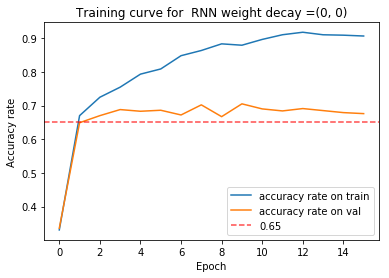

The best accuracy for weight decay=(0, 0) is  0.705  when the epoch =9
--------------------------------------------
Rnn parameter tuning for different weight_decay, current weight decay= (0.001, 5e-05)
epoch  0  accuracy on training dataset:  0.33632  accuracy on val dataset:  0.331
epoch  1  accuracy on training dataset:  0.62942  accuracy on val dataset:  0.607
epoch  2  accuracy on training dataset:  0.66939  accuracy on val dataset:  0.652
epoch  3  accuracy on training dataset:  0.69965  accuracy on val dataset:  0.679
epoch  4  accuracy on training dataset:  0.71837  accuracy on val dataset:  0.682
epoch  5  accuracy on training dataset:  0.72744  accuracy on val dataset:  0.688
epoch  6  accuracy on training dataset:  0.7399  accuracy on val dataset:  0.691
epoch  7  accuracy on training dataset:  0.74009  accuracy on val dataset:  0.702
epoch  8  accuracy on training dataset:  0.74619  accuracy on val dataset:  0.697
epoch  9  accuracy on training dataset:  0.7528  accuracy on 

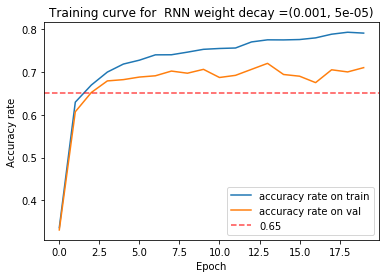

The best accuracy for weight decay=(0.001, 5e-05) is  0.72  when the epoch =13
--------------------------------------------
Rnn parameter tuning for different weight_decay, current weight decay= (0.005, 0.0005)
epoch  0  accuracy on training dataset:  0.32881  accuracy on val dataset:  0.315
epoch  1  accuracy on training dataset:  0.61018  accuracy on val dataset:  0.598
epoch  2  accuracy on training dataset:  0.62196  accuracy on val dataset:  0.601
epoch  3  accuracy on training dataset:  0.62953  accuracy on val dataset:  0.603
epoch  4  accuracy on training dataset:  0.62796  accuracy on val dataset:  0.597
epoch  5  accuracy on training dataset:  0.63175  accuracy on val dataset:  0.629
epoch  6  accuracy on training dataset:  0.63895  accuracy on val dataset:  0.613
epoch  7  accuracy on training dataset:  0.62695  accuracy on val dataset:  0.616
epoch  8  accuracy on training dataset:  0.63445  accuracy on val dataset:  0.61
epoch  9  accuracy on training dataset:  0.62696  ac

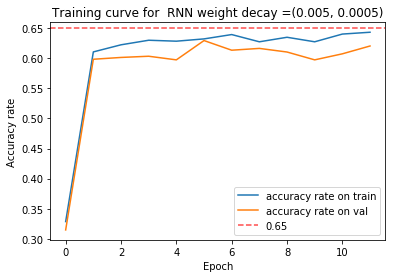

The best accuracy for weight decay=(0.005, 0.0005) is  0.629  when the epoch =5
--------------------------------------------


In [10]:
weight_decays = [(0,0),(0.001,0.00005),(0.005, 0.0005)]
all_record = []
for weight_decay in weight_decays:
    save_file_name = '../save_model/rnn_weight_decays_'+str(weight_decay)
    model = Rnn(300,300,TEXT.vocab)
    model.cuda()
    
    para1_list = []
    para2_list = []
    
    for i,j in model.named_parameters():
        if j.requires_grad:
            if 'linear' in i:
                para1_list.append(j)
            else:
                para2_list.append(j)
    optimizer = torch.optim.Adam([{'params':para1_list, 'lr':0.005, 'weight_decay':weight_decay[0]},
                     {'params':para2_list, 'lr':0.005, 'weight_decay':weight_decay[1]}])
    
    print('Rnn parameter tuning for different weight_decay, current weight decay=', weight_decay)
    train_accuracy_list, val_accuracy_list = complete_process(model, snli_train_iter, snli_val_iter, optimizer, save_file_name)
    
    plot_training_curve( train_accuracy_list, val_accuracy_list,' RNN weight decay ='+str(weight_decay))
    print('The best accuracy for weight decay='+str(weight_decay)+' is ',max(val_accuracy_list), ' when the epoch ='+str(np.argmax(val_accuracy_list)))
    all_record.append([weight_decay, np.argmax(val_accuracy_list), max(val_accuracy_list)])
    print('--------------------------------------------')
    

In [51]:
pd.DataFrame(all_record, columns=['classifier,GRU', 'best_epoch','best accuracy(validation data)'])

,"classifier,GRU",best_epoch,best accuracy(validation data)
0,"(0, 0)",9,0.705
1,"(0.001, 5e-05)",13,0.720
2,"(0.005, 0.0005)",5,0.629


<h2>Hypter-parameter tuning for CNN with different weight_decay</h2>

CNN parameter tuning for different weight_decay, current weight decay= 0.0
epoch  0  accuracy on training dataset:  0.33074  accuracy on val dataset:  0.343
epoch  1  accuracy on training dataset:  0.67017  accuracy on val dataset:  0.628
epoch  2  accuracy on training dataset:  0.69849  accuracy on val dataset:  0.641
epoch  3  accuracy on training dataset:  0.73652  accuracy on val dataset:  0.651
epoch  4  accuracy on training dataset:  0.76502  accuracy on val dataset:  0.641
epoch  5  accuracy on training dataset:  0.79224  accuracy on val dataset:  0.633
epoch  6  accuracy on training dataset:  0.82319  accuracy on val dataset:  0.636
epoch  7  accuracy on training dataset:  0.84654  accuracy on val dataset:  0.636
epoch  8  accuracy on training dataset:  0.8738  accuracy on val dataset:  0.638
epoch  9  accuracy on training dataset:  0.8997  accuracy on val dataset:  0.633


/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


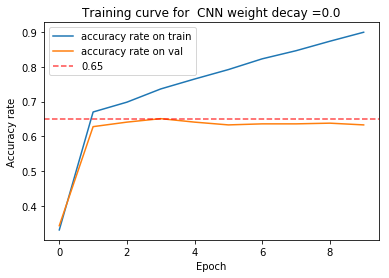

The best accuracy for weight decay=0.0 is  0.651  when the epoch =3
--------------------------------------------
CNN parameter tuning for different weight_decay, current weight decay= 0.0001
epoch  0  accuracy on training dataset:  0.338  accuracy on val dataset:  0.34
epoch  1  accuracy on training dataset:  0.66964  accuracy on val dataset:  0.64
epoch  2  accuracy on training dataset:  0.70165  accuracy on val dataset:  0.657
epoch  3  accuracy on training dataset:  0.72867  accuracy on val dataset:  0.661
epoch  4  accuracy on training dataset:  0.75399  accuracy on val dataset:  0.668
epoch  5  accuracy on training dataset:  0.77299  accuracy on val dataset:  0.65
epoch  6  accuracy on training dataset:  0.79991  accuracy on val dataset:  0.651
epoch  7  accuracy on training dataset:  0.82906  accuracy on val dataset:  0.641
epoch  8  accuracy on training dataset:  0.85243  accuracy on val dataset:  0.633
epoch  9  accuracy on training dataset:  0.86369  accuracy on val dataset:  

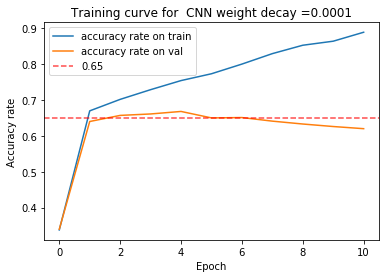

The best accuracy for weight decay=0.0001 is  0.668  when the epoch =4
--------------------------------------------
CNN parameter tuning for different weight_decay, current weight decay= 0.001
epoch  0  accuracy on training dataset:  0.33203  accuracy on val dataset:  0.338
epoch  1  accuracy on training dataset:  0.64486  accuracy on val dataset:  0.623
epoch  2  accuracy on training dataset:  0.67269  accuracy on val dataset:  0.642
epoch  3  accuracy on training dataset:  0.68601  accuracy on val dataset:  0.643
epoch  4  accuracy on training dataset:  0.70477  accuracy on val dataset:  0.649
epoch  5  accuracy on training dataset:  0.71478  accuracy on val dataset:  0.647
epoch  6  accuracy on training dataset:  0.72791  accuracy on val dataset:  0.658
epoch  7  accuracy on training dataset:  0.73938  accuracy on val dataset:  0.646
epoch  8  accuracy on training dataset:  0.75293  accuracy on val dataset:  0.648
epoch  9  accuracy on training dataset:  0.76049  accuracy on val dat

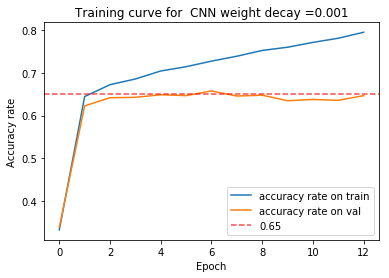

The best accuracy for weight decay=0.001 is  0.658  when the epoch =6
--------------------------------------------


[[0.0, 3, 0.651], [0.0001, 4, 0.668], [0.001, 6, 0.658]]

In [13]:
weight_decays = [0.0, 0.0001, 0.001]
all_record = []
for weight_decay in weight_decays:
    save_file_name = '../save_model/cnn_weight_decays_'+str(weight_decay)
    model = CNN(in_channels=300, out_channels=300, kernel_size=3, vocab=TEXT.vocab)
    model.cuda()
    
    optimizer = torch.optim.Adagrad([p for p in model.parameters() if p.requires_grad],lr = 0.005, weight_decay=weight_decay)
    
    print('CNN parameter tuning for different weight_decay, current weight decay=', weight_decay)
    train_accuracy_list, val_accuracy_list = complete_process(model, snli_train_iter, snli_val_iter, optimizer, save_file_name)
    
    plot_training_curve( train_accuracy_list, val_accuracy_list,' CNN weight decay ='+str(weight_decay))
    print('The best accuracy for weight decay='+str(weight_decay)+' is ',max(val_accuracy_list), ' when the epoch ='+str(np.argmax(val_accuracy_list)))
    all_record.append([weight_decay, np.argmax(val_accuracy_list), max(val_accuracy_list)])
    print('--------------------------------------------')
all_record   

In [52]:
pd.DataFrame(all_record, columns=['CNN weiget', 'best_epoch','best accuracy(validation data)'])

,CNN weiget,best_epoch,best accuracy(validation data)
0,0.0000,3,0.651
1,0.0001,4,0.668
2,0.0010,6,0.658


<h2>Hypter-parameter tuning for RNN with different hidden_size</h2>

Rnn parameter tuning for different hidden_size, current hidden_size= 100
epoch  0  accuracy on training dataset:  0.33637  accuracy on val dataset:  0.331
epoch  1  accuracy on training dataset:  0.64429  accuracy on val dataset:  0.615
epoch  2  accuracy on training dataset:  0.66085  accuracy on val dataset:  0.624
epoch  3  accuracy on training dataset:  0.69644  accuracy on val dataset:  0.665
epoch  4  accuracy on training dataset:  0.71076  accuracy on val dataset:  0.676
epoch  5  accuracy on training dataset:  0.72347  accuracy on val dataset:  0.674
epoch  6  accuracy on training dataset:  0.72275  accuracy on val dataset:  0.687
epoch  7  accuracy on training dataset:  0.72687  accuracy on val dataset:  0.684
epoch  8  accuracy on training dataset:  0.74387  accuracy on val dataset:  0.685
epoch  9  accuracy on training dataset:  0.74518  accuracy on val dataset:  0.683
epoch  10  accuracy on training dataset:  0.75026  accuracy on val dataset:  0.664
epoch  11  accuracy on t

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Rnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


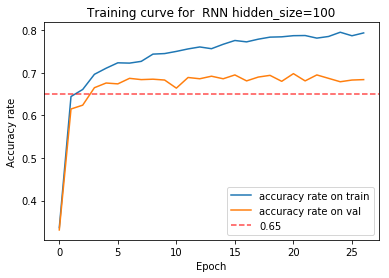

The best accuracy for hidden_size=100 is  0.698  when the epoch =20
--------------------------------------------
Rnn parameter tuning for different hidden_size, current hidden_size= 200
epoch  0  accuracy on training dataset:  0.33031  accuracy on val dataset:  0.325
epoch  1  accuracy on training dataset:  0.64189  accuracy on val dataset:  0.631
epoch  2  accuracy on training dataset:  0.67346  accuracy on val dataset:  0.65
epoch  3  accuracy on training dataset:  0.70008  accuracy on val dataset:  0.658
epoch  4  accuracy on training dataset:  0.71916  accuracy on val dataset:  0.678
epoch  5  accuracy on training dataset:  0.72217  accuracy on val dataset:  0.676
epoch  6  accuracy on training dataset:  0.72969  accuracy on val dataset:  0.686
epoch  7  accuracy on training dataset:  0.7298  accuracy on val dataset:  0.674
epoch  8  accuracy on training dataset:  0.74233  accuracy on val dataset:  0.698
epoch  9  accuracy on training dataset:  0.7532  accuracy on val dataset:  0.6

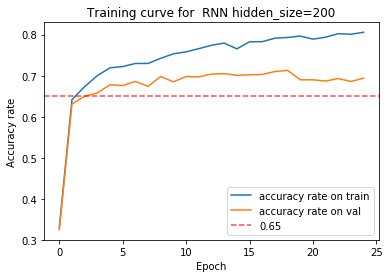

The best accuracy for hidden_size=200 is  0.713  when the epoch =18
--------------------------------------------
Rnn parameter tuning for different hidden_size, current hidden_size= 300
epoch  0  accuracy on training dataset:  0.332  accuracy on val dataset:  0.338
epoch  1  accuracy on training dataset:  0.63988  accuracy on val dataset:  0.627
epoch  2  accuracy on training dataset:  0.68141  accuracy on val dataset:  0.661
epoch  3  accuracy on training dataset:  0.70543  accuracy on val dataset:  0.682
epoch  4  accuracy on training dataset:  0.71438  accuracy on val dataset:  0.678
epoch  5  accuracy on training dataset:  0.72821  accuracy on val dataset:  0.684
epoch  6  accuracy on training dataset:  0.72909  accuracy on val dataset:  0.698
epoch  7  accuracy on training dataset:  0.74811  accuracy on val dataset:  0.722
epoch  8  accuracy on training dataset:  0.75337  accuracy on val dataset:  0.708
epoch  9  accuracy on training dataset:  0.74491  accuracy on val dataset:  0.

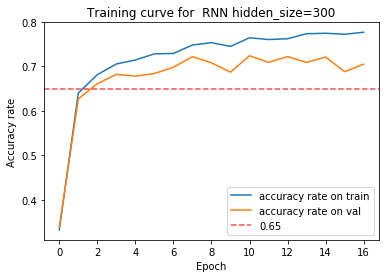

The best accuracy for hidden_size=300 is  0.724  when the epoch =10
--------------------------------------------


In [93]:
hidden_size_list = [100,200,300]
all_record = []
for hidden_size in hidden_size_list:
    save_file_name = '../save_model/rnn_hidden_size_'+str(hidden_size)
    model = Rnn(300,hidden_size,TEXT.vocab)
    model.cuda()
    
    para1_list = []
    para2_list = []
    
    for i,j in model.named_parameters():
        if j.requires_grad:
            if 'linear' in i:
                para1_list.append(j)
            else:
                para2_list.append(j)
    optimizer = torch.optim.Adam([{'params':para1_list, 'lr':0.005, 'weight_decay':0.001},
                     {'params':para2_list, 'lr':0.005, 'weight_decay':0.00005}])
    
    print('Rnn parameter tuning for different hidden_size, current hidden_size=', hidden_size)
    train_accuracy_list, val_accuracy_list = complete_process(model, snli_train_iter, snli_val_iter, optimizer, save_file_name)
    
    plot_training_curve( train_accuracy_list, val_accuracy_list,' RNN hidden_size='+str(hidden_size))
    print('The best accuracy for hidden_size='+str(hidden_size)+' is ',max(val_accuracy_list), ' when the epoch ='+str(np.argmax(val_accuracy_list)))
    all_record.append([hidden_size, np.argmax(val_accuracy_list), max(val_accuracy_list)])
    print('--------------------------------------------')
    

Rnn parameter tuning for different hidden_size, current hidden_size= 400
epoch  0  accuracy on training dataset:  0.33635  accuracy on val dataset:  0.331
epoch  1  accuracy on training dataset:  0.64457  accuracy on val dataset:  0.629
epoch  2  accuracy on training dataset:  0.66853  accuracy on val dataset:  0.637
epoch  3  accuracy on training dataset:  0.70607  accuracy on val dataset:  0.674
epoch  4  accuracy on training dataset:  0.71563  accuracy on val dataset:  0.683
epoch  5  accuracy on training dataset:  0.72213  accuracy on val dataset:  0.678
epoch  6  accuracy on training dataset:  0.72394  accuracy on val dataset:  0.69
epoch  7  accuracy on training dataset:  0.74161  accuracy on val dataset:  0.693
epoch  8  accuracy on training dataset:  0.73805  accuracy on val dataset:  0.684
epoch  9  accuracy on training dataset:  0.75186  accuracy on val dataset:  0.674
epoch  10  accuracy on training dataset:  0.75214  accuracy on val dataset:  0.693
epoch  11  accuracy on tr

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Rnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


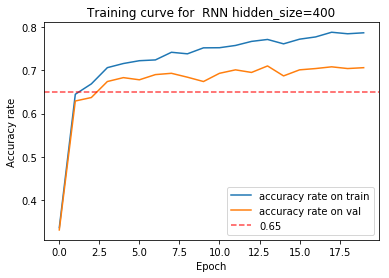

The best accuracy for hidden_size=400 is  0.71  when the epoch =13
--------------------------------------------


In [95]:
hidden_size_list = [400]
all_record = []
for hidden_size in hidden_size_list:
    save_file_name = '../save_model/rnn_hidden_size_'+str(hidden_size)
    model = Rnn(300,hidden_size,TEXT.vocab)
    model.cuda()
    
    para1_list = []
    para2_list = []
    
    for i,j in model.named_parameters():
        if j.requires_grad:
            if 'linear' in i:
                para1_list.append(j)
            else:
                para2_list.append(j)
    optimizer = torch.optim.Adam([{'params':para1_list, 'lr':0.005, 'weight_decay':0.001},
                     {'params':para2_list, 'lr':0.005, 'weight_decay':0.00005}])
    
    print('Rnn parameter tuning for different hidden_size, current hidden_size=', hidden_size)
    train_accuracy_list, val_accuracy_list = complete_process(model, snli_train_iter, snli_val_iter, optimizer, save_file_name)
    
    plot_training_curve( train_accuracy_list, val_accuracy_list,' RNN hidden_size='+str(hidden_size))
    print('The best accuracy for hidden_size='+str(hidden_size)+' is ',max(val_accuracy_list), ' when the epoch ='+str(np.argmax(val_accuracy_list)))
    all_record.append([hidden_size, np.argmax(val_accuracy_list), max(val_accuracy_list)])
    print('--------------------------------------------')

In [59]:
pd.DataFrame(all_record, columns=['RNN_hidden_size', 'best_epoch','best accuracy(validation data)'])

,RNN_hidden_size,best_epoch,best accuracy(validation data)
0,100,20,0.698
1,200,18,0.713
2,300,10,0.724
3,400,13,0.710


<h2>Hypter-parameter tuning for CNN with different hidden_size(out_channels)</h2>

CNN parameter tuning for different hidden_size, current hidden_size= 100
epoch  0  accuracy on training dataset:  0.34191  accuracy on val dataset:  0.329
epoch  1  accuracy on training dataset:  0.64301  accuracy on val dataset:  0.622
epoch  2  accuracy on training dataset:  0.66288  accuracy on val dataset:  0.639
epoch  3  accuracy on training dataset:  0.67177  accuracy on val dataset:  0.631
epoch  4  accuracy on training dataset:  0.68529  accuracy on val dataset:  0.646
epoch  5  accuracy on training dataset:  0.69605  accuracy on val dataset:  0.642
epoch  6  accuracy on training dataset:  0.70305  accuracy on val dataset:  0.647
epoch  7  accuracy on training dataset:  0.71072  accuracy on val dataset:  0.647
epoch  8  accuracy on training dataset:  0.71862  accuracy on val dataset:  0.651
epoch  9  accuracy on training dataset:  0.72519  accuracy on val dataset:  0.653
epoch  10  accuracy on training dataset:  0.73186  accuracy on val dataset:  0.656
epoch  11  accuracy on t

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


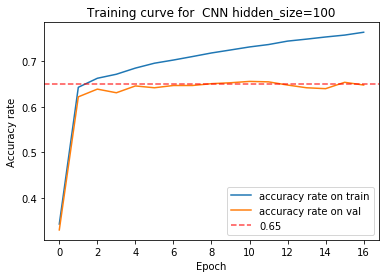

The best accuracy for hidden_size=100 is  0.656  when the epoch =10
--------------------------------------------
CNN parameter tuning for different hidden_size, current hidden_size= 200
epoch  0  accuracy on training dataset:  0.33635  accuracy on val dataset:  0.331
epoch  1  accuracy on training dataset:  0.66544  accuracy on val dataset:  0.633
epoch  2  accuracy on training dataset:  0.69011  accuracy on val dataset:  0.647
epoch  3  accuracy on training dataset:  0.71023  accuracy on val dataset:  0.644
epoch  4  accuracy on training dataset:  0.73217  accuracy on val dataset:  0.645
epoch  5  accuracy on training dataset:  0.75105  accuracy on val dataset:  0.652
epoch  6  accuracy on training dataset:  0.7669  accuracy on val dataset:  0.641
epoch  7  accuracy on training dataset:  0.78214  accuracy on val dataset:  0.635
epoch  8  accuracy on training dataset:  0.79881  accuracy on val dataset:  0.644
epoch  9  accuracy on training dataset:  0.81398  accuracy on val dataset:  0

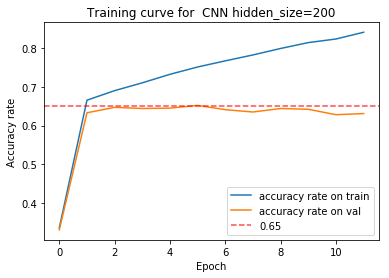

The best accuracy for hidden_size=200 is  0.652  when the epoch =5
--------------------------------------------
CNN parameter tuning for different hidden_size, current hidden_size= 300
epoch  0  accuracy on training dataset:  0.332  accuracy on val dataset:  0.338
epoch  1  accuracy on training dataset:  0.66349  accuracy on val dataset:  0.64
epoch  2  accuracy on training dataset:  0.69774  accuracy on val dataset:  0.671
epoch  3  accuracy on training dataset:  0.72563  accuracy on val dataset:  0.66
epoch  4  accuracy on training dataset:  0.75082  accuracy on val dataset:  0.66
epoch  5  accuracy on training dataset:  0.7739  accuracy on val dataset:  0.657
epoch  6  accuracy on training dataset:  0.7975  accuracy on val dataset:  0.661
epoch  7  accuracy on training dataset:  0.81956  accuracy on val dataset:  0.648
epoch  8  accuracy on training dataset:  0.84116  accuracy on val dataset:  0.645


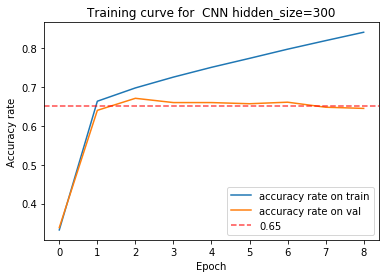

The best accuracy for hidden_size=300 is  0.671  when the epoch =2
--------------------------------------------
CNN parameter tuning for different hidden_size, current hidden_size= 400
epoch  0  accuracy on training dataset:  0.33201  accuracy on val dataset:  0.338
epoch  1  accuracy on training dataset:  0.6701  accuracy on val dataset:  0.64
epoch  2  accuracy on training dataset:  0.7019  accuracy on val dataset:  0.661
epoch  3  accuracy on training dataset:  0.73569  accuracy on val dataset:  0.637
epoch  4  accuracy on training dataset:  0.7587  accuracy on val dataset:  0.647
epoch  5  accuracy on training dataset:  0.79151  accuracy on val dataset:  0.648
epoch  6  accuracy on training dataset:  0.82119  accuracy on val dataset:  0.637
epoch  7  accuracy on training dataset:  0.84663  accuracy on val dataset:  0.635
epoch  8  accuracy on training dataset:  0.87861  accuracy on val dataset:  0.621


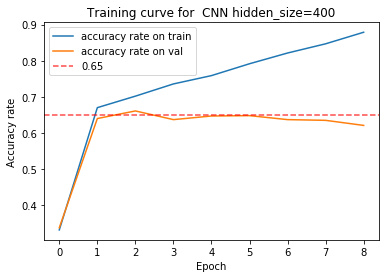

The best accuracy for hidden_size=400 is  0.661  when the epoch =2
--------------------------------------------


In [109]:
hidden_size_list = [100,200,300, 400]
all_record = []
for hidden_size in hidden_size_list:
    save_file_name = '../save_model/cnn_hidden_size_'+str(hidden_size)
    model = CNN(in_channels=300, out_channels=hidden_size, kernel_size=3, vocab = TEXT.vocab)
    model.cuda()
    
    optimizer = torch.optim.Adagrad([p for p in model.parameters() if p.requires_grad],lr = 0.005, weight_decay=0.0001)
    
    print('CNN parameter tuning for different hidden_size, current hidden_size=', hidden_size)
    train_accuracy_list, val_accuracy_list = complete_process(model, snli_train_iter, snli_val_iter,optimizer, save_file_name)
    plot_training_curve( train_accuracy_list, val_accuracy_list,' CNN hidden_size='+str(hidden_size))
    print('The best accuracy for hidden_size='+str(hidden_size)+' is ',max(val_accuracy_list), ' when the epoch ='+str(np.argmax(val_accuracy_list)))
    all_record.append([hidden_size, np.argmax(val_accuracy_list), max(val_accuracy_list)])
    print('--------------------------------------------')
    

In [60]:
pd.DataFrame(all_record, columns=['CNN_hidden_size', 'best_epoch','best accuracy(validation data)'])

,CNN_hidden_size,best_epoch,best accuracy(validation data)
0,100,10,0.656
1,200,5,0.652
2,300,2,0.671
3,400,2,0.661


<h2>Experiment with different ways of interacting the two encoded sentences
(concatenation, element-wise multiplication, etc)</h2>


In [9]:

class Rnn_element_wise_multip(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, vocab, is_separate=False):
        
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vocab = vocab
        self.embedding = torch.nn.Embedding(self.vocab.vectors.shape[0],vocab.vectors.shape[1])
        self.embedding.weight = torch.nn.Parameter(self.vocab.vectors, requires_grad=False)
        self.gru_1 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        if is_separate:
            self.gru_2 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        else:
            self.gru_2 = self.gru_1
            
        
        h_0 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_0, mean=0, std=0.001)
        self.h_0 = torch.nn.Parameter(h_0,requires_grad=True)
        
        h_1 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_1, mean=0, std=0.001)
        self.h_1 = torch.nn.Parameter(h_1,requires_grad=True)
        
        self.linear_1 = torch.nn.Linear(self.hidden_size,3)
        
    
    
    def forward(self, X_1, X_2):
        data_1, len_1 = X_1[0], X_1[1]
        data_2, len_2 = X_2[0], X_2[1]
        batch_size = data_1.shape[0]

        h_0 = torch.cat([self.h_0]*batch_size,dim=0)
        h_0 = torch.stack([h_0]*2, dim=0)
        h_1 = torch.cat([self.h_1]*batch_size,dim=0)
        h_1 = torch.stack([h_1]*2, dim=0)
        
        sorted_index_1 = np.argsort(-len_1)
        sorted_index_2 = np.argsort(-len_2)
        
        len_1 = len_1[sorted_index_1]
        len_2 = len_2[sorted_index_2]
        
        data_1 = data_1[sorted_index_1]
        data_2 = data_2[sorted_index_2]
        
        data_1 = self.embedding(data_1)
        data_2 = self.embedding(data_2)
        
        data_1 = torch.nn.utils.rnn.pack_padded_sequence(data_1,len_1,batch_first=True)
        data_2 = torch.nn.utils.rnn.pack_padded_sequence(data_2,len_2,batch_first=True)
        
        
        reverse_index_1 = list(enumerate(sorted_index_1))
        reverse_index_1 = sorted(reverse_index_1, key = lambda x: x[1])
        reverse_index_1 = np.array(reverse_index_1)
        reverse_index_1 = reverse_index_1[:,0]
        
        reverse_index_2 = list(enumerate(sorted_index_2))
        reverse_index_2 = sorted(reverse_index_2, key = lambda x: x[1])
        reverse_index_2 = np.array(reverse_index_2)
        reverse_index_2 = reverse_index_2[:,0]
        
        output_1,h_n_1 = self.gru_1(data_1, h_0)
        output_2,h_n_2 = self.gru_2(data_2, h_1)
        
        h_n_1,_ = h_n_1.transpose(0,1).max(dim=1)
        h_n_2,_ = h_n_2.transpose(0,1).max(dim=1)
        
        h_n_1 = h_n_1[reverse_index_1]
        h_n_2 = h_n_2[reverse_index_2] 
        
        h_n = h_n_1*h_n_2
        
        pred = self.linear_1(h_n)
        
        return pred
    
class Rnn_average(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, vocab, is_separate=False):
        
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vocab = vocab
        self.embedding = torch.nn.Embedding(self.vocab.vectors.shape[0],vocab.vectors.shape[1])
        self.embedding.weight = torch.nn.Parameter(self.vocab.vectors, requires_grad=False)
        self.gru_1 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        if is_separate:
            self.gru_2 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        else:
            self.gru_2 = self.gru_1
            
        
        h_0 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_0, mean=0, std=0.001)
        self.h_0 = torch.nn.Parameter(h_0,requires_grad=True)
        
        h_1 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_1, mean=0, std=0.001)
        self.h_1 = torch.nn.Parameter(h_1,requires_grad=True)
        
        self.linear_1 = torch.nn.Linear(self.hidden_size,3)
        
    
    
    def forward(self, X_1, X_2):
        data_1, len_1 = X_1[0], X_1[1]
        data_2, len_2 = X_2[0], X_2[1]
        batch_size = data_1.shape[0]

        h_0 = torch.cat([self.h_0]*batch_size,dim=0)
        h_0 = torch.stack([h_0]*2, dim=0)
        h_1 = torch.cat([self.h_1]*batch_size,dim=0)
        h_1 = torch.stack([h_1]*2, dim=0)
        
        sorted_index_1 = np.argsort(-len_1)
        sorted_index_2 = np.argsort(-len_2)
        
        len_1 = len_1[sorted_index_1]
        len_2 = len_2[sorted_index_2]
        
        data_1 = data_1[sorted_index_1]
        data_2 = data_2[sorted_index_2]
        
        data_1 = self.embedding(data_1)
        data_2 = self.embedding(data_2)
        
        data_1 = torch.nn.utils.rnn.pack_padded_sequence(data_1,len_1,batch_first=True)
        data_2 = torch.nn.utils.rnn.pack_padded_sequence(data_2,len_2,batch_first=True)
        
        
        reverse_index_1 = list(enumerate(sorted_index_1))
        reverse_index_1 = sorted(reverse_index_1, key = lambda x: x[1])
        reverse_index_1 = np.array(reverse_index_1)
        reverse_index_1 = reverse_index_1[:,0]
        
        reverse_index_2 = list(enumerate(sorted_index_2))
        reverse_index_2 = sorted(reverse_index_2, key = lambda x: x[1])
        reverse_index_2 = np.array(reverse_index_2)
        reverse_index_2 = reverse_index_2[:,0]
        
        output_1,h_n_1 = self.gru_1(data_1, h_0)
        output_2,h_n_2 = self.gru_2(data_2, h_1)
        
        h_n_1,_ = h_n_1.transpose(0,1).max(dim=1)
        h_n_2,_ = h_n_2.transpose(0,1).max(dim=1)
        
        h_n_1 = h_n_1[reverse_index_1]
        h_n_2 = h_n_2[reverse_index_2] 
        
        h_n = (h_n_1 + h_n_2)/2
        
        pred = self.linear_1(h_n)
        
        return pred

    
class Rnn_max(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, vocab, is_separate=False):
        
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vocab = vocab
        self.embedding = torch.nn.Embedding(self.vocab.vectors.shape[0],vocab.vectors.shape[1])
        self.embedding.weight = torch.nn.Parameter(self.vocab.vectors, requires_grad=False)
        self.gru_1 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        if is_separate:
            self.gru_2 = torch.nn.GRU(input_size=self.input_size, hidden_size= self.hidden_size, num_layers=1,
                               batch_first=True, bidirectional=True)
        else:
            self.gru_2 = self.gru_1
            
        
        h_0 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_0, mean=0, std=0.001)
        self.h_0 = torch.nn.Parameter(h_0,requires_grad=True)
        
        h_1 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_1, mean=0, std=0.001)
        self.h_1 = torch.nn.Parameter(h_1,requires_grad=True)
        
        self.linear_1 = torch.nn.Linear(self.hidden_size,3)
        
    
    
    def forward(self, X_1, X_2):
        data_1, len_1 = X_1[0], X_1[1]
        data_2, len_2 = X_2[0], X_2[1]
        batch_size = data_1.shape[0]

        h_0 = torch.cat([self.h_0]*batch_size,dim=0)
        h_0 = torch.stack([h_0]*2, dim=0)
        h_1 = torch.cat([self.h_1]*batch_size,dim=0)
        h_1 = torch.stack([h_1]*2, dim=0)
        
        sorted_index_1 = np.argsort(-len_1)
        sorted_index_2 = np.argsort(-len_2)
        
        len_1 = len_1[sorted_index_1]
        len_2 = len_2[sorted_index_2]
        
        data_1 = data_1[sorted_index_1]
        data_2 = data_2[sorted_index_2]
        
        data_1 = self.embedding(data_1)
        data_2 = self.embedding(data_2)
        
        data_1 = torch.nn.utils.rnn.pack_padded_sequence(data_1,len_1,batch_first=True)
        data_2 = torch.nn.utils.rnn.pack_padded_sequence(data_2,len_2,batch_first=True)
        
        
        reverse_index_1 = list(enumerate(sorted_index_1))
        reverse_index_1 = sorted(reverse_index_1, key = lambda x: x[1])
        reverse_index_1 = np.array(reverse_index_1)
        reverse_index_1 = reverse_index_1[:,0]
        
        reverse_index_2 = list(enumerate(sorted_index_2))
        reverse_index_2 = sorted(reverse_index_2, key = lambda x: x[1])
        reverse_index_2 = np.array(reverse_index_2)
        reverse_index_2 = reverse_index_2[:,0]
        
        output_1,h_n_1 = self.gru_1(data_1, h_0)
        output_2,h_n_2 = self.gru_2(data_2, h_1)
        
        h_n_1,_ = h_n_1.transpose(0,1).max(dim=1)
        h_n_2,_ = h_n_2.transpose(0,1).max(dim=1)
        
        h_n_1 = h_n_1[reverse_index_1]
        h_n_2 = h_n_2[reverse_index_2] 
        
        h_n_1.unsqueeze_(dim=1)
        h_n_2.unsqueeze_(dim=1)
        h_n = torch.cat([h_n_1,h_n_2],dim=1)
        h_n ,_= torch.max(h_n,dim=1)
        
        
        
        pred = self.linear_1(h_n)
        
        return pred


Differently interacting the two encoded sentences Rnn_max
epoch  0  accuracy on training dataset:  0.33635  accuracy on val dataset:  0.331
epoch  1  accuracy on training dataset:  0.65981  accuracy on val dataset:  0.637
epoch  2  accuracy on training dataset:  0.71853  accuracy on val dataset:  0.679
epoch  3  accuracy on training dataset:  0.76562  accuracy on val dataset:  0.727
epoch  4  accuracy on training dataset:  0.79583  accuracy on val dataset:  0.74
epoch  5  accuracy on training dataset:  0.82207  accuracy on val dataset:  0.734
epoch  6  accuracy on training dataset:  0.8555  accuracy on val dataset:  0.74
epoch  7  accuracy on training dataset:  0.88586  accuracy on val dataset:  0.745
epoch  8  accuracy on training dataset:  0.91717  accuracy on val dataset:  0.738
epoch  9  accuracy on training dataset:  0.94323  accuracy on val dataset:  0.726
epoch  10  accuracy on training dataset:  0.96327  accuracy on val dataset:  0.719
epoch  11  accuracy on training dataset:  

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Rnn_max. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


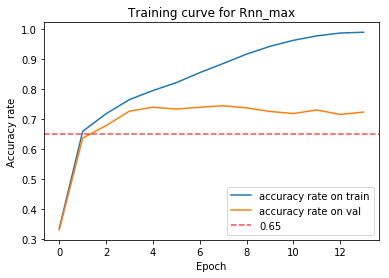

The best accuracy is  0.745  when the epoch =7
--------------------------------------------
Differently interacting the two encoded sentences Rnn_average
epoch  0  accuracy on training dataset:  0.32517  accuracy on val dataset:  0.32
epoch  1  accuracy on training dataset:  0.62523  accuracy on val dataset:  0.616
epoch  2  accuracy on training dataset:  0.65268  accuracy on val dataset:  0.628
epoch  3  accuracy on training dataset:  0.66879  accuracy on val dataset:  0.641
epoch  4  accuracy on training dataset:  0.68897  accuracy on val dataset:  0.643
epoch  5  accuracy on training dataset:  0.70354  accuracy on val dataset:  0.647
epoch  6  accuracy on training dataset:  0.72962  accuracy on val dataset:  0.654
epoch  7  accuracy on training dataset:  0.74482  accuracy on val dataset:  0.653
epoch  8  accuracy on training dataset:  0.77803  accuracy on val dataset:  0.655
epoch  9  accuracy on training dataset:  0.80576  accuracy on val dataset:  0.628
epoch  10  accuracy on trai

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Rnn_average. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


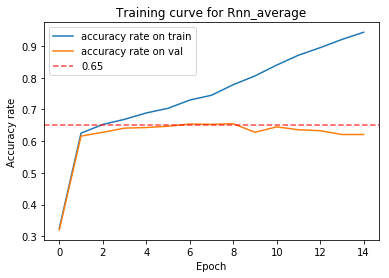

The best accuracy is  0.655  when the epoch =8
--------------------------------------------
Differently interacting the two encoded sentences Rnn_element_wise_multip
epoch  0  accuracy on training dataset:  0.33634  accuracy on val dataset:  0.337
epoch  1  accuracy on training dataset:  0.66269  accuracy on val dataset:  0.653
epoch  2  accuracy on training dataset:  0.70597  accuracy on val dataset:  0.683
epoch  3  accuracy on training dataset:  0.74322  accuracy on val dataset:  0.7
epoch  4  accuracy on training dataset:  0.78003  accuracy on val dataset:  0.725
epoch  5  accuracy on training dataset:  0.80365  accuracy on val dataset:  0.73
epoch  6  accuracy on training dataset:  0.83682  accuracy on val dataset:  0.724
epoch  7  accuracy on training dataset:  0.86402  accuracy on val dataset:  0.734
epoch  8  accuracy on training dataset:  0.89956  accuracy on val dataset:  0.722
epoch  9  accuracy on training dataset:  0.92323  accuracy on val dataset:  0.727
epoch  10  accura

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Rnn_element_wise_multip. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


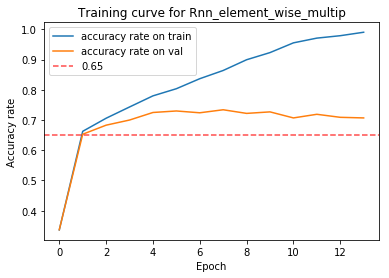

The best accuracy is  0.734  when the epoch =7
--------------------------------------------


[['max', 7, 0.745], ['averge', 8, 0.655], ['element_wise_multip', 7, 0.734]]

In [40]:
all_record = []
for model_define in [Rnn_max, Rnn_average, Rnn_element_wise_multip]:
    model = model_define(input_size=300, hidden_size=300, vocab=TEXT.vocab)
    model = model.cuda()
    if isinstance(model,Rnn_max):
        kind = 'max'
    if isinstance(model, Rnn_average):
        kind = 'averge'
    elif isinstance(model, Rnn_element_wise_multip):
        kind = 'element_wise_multip'
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad])
    print('Differently interacting the two encoded sentences '+model.__class__.__name__)
    save_file_name = '../save_model/'+model.__class__.__name__
    train_accuracy_list, val_accuracy_list = complete_process(model, snli_train_iter, snli_val_iter,optimizer, save_file_name)
    plot_training_curve( train_accuracy_list, val_accuracy_list,model.__class__.__name__)
    print('The best accuracy is ',max(val_accuracy_list), ' when the epoch ='+str(np.argmax(val_accuracy_list)))
    all_record.append([kind, np.argmax(val_accuracy_list), max(val_accuracy_list)])
    print('--------------------------------------------')
all_record

In [62]:
pd.DataFrame(all_record, columns=['RNN-based interaction', 'best_epoch','best accuracy(validation data)'])

,RNN-based interaction,best_epoch,best accuracy(validation data)
0,concatenation,13,0.720
1,max,7,0.745
2,averge,8,0.655
3,element_wise_multip,7,0.734


# take your best model based on validation performance and highlight 3 correct and 3 incorrect predictions in the validation set.

In [69]:
model = torch.load('../save_model/Rnn_max')
retrieve_correct_and_incorrect_data(model, snli_val_iter)

---------------------------correct----------------------------------
Text1:  a balding man wearing a brown jacket with his hands crossed and his head tilted down .
Text2:  a man wearing a brown jacket with his hands crossed and his head tilted down .
Correct Relationship:  entailment   Predicted Relationship:  entailment

Text1:  construction workers walk towards their next job .
Text2:  the workers are walking outside
Correct Relationship:  entailment   Predicted Relationship:  entailment

Text1:  a man is sitting in a chair and looking at something that he is holding .
Text2:  a man is sitting in a chair pondering life .
Correct Relationship:  neutral   Predicted Relationship:  neutral

Text1:  a young boy and girl playing baseball in a grassy field .
Text2:  kids play baseball
Correct Relationship:  entailment   Predicted Relationship:  entailment

Text1:  dozens of street performers in fuchsia , red , yellow and black outfits are dancing and singing along a city street .
Text2:  th

# 3.2 Evaluating on MultiNLI


In [10]:
GENRE.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {' UNK ': 0,
             'fiction': 5,
             'government': 4,
             'slate': 2,
             'telephone': 1,
             'travel': 3})

In [11]:
mnli_val_examples_list = [[],[],[],[],[]]
for example in mnli_val_examples:
    mnli_val_examples_list[GENRE.vocab.stoi[example.genre]-1].append(example)
    
mnli_train_examples_list = [[],[],[],[],[]]
for example in mnli_train_examples:
    mnli_train_examples_list[GENRE.vocab.stoi[example.genre]-1].append(example)

In [12]:
print('-------val----------')
for i,examples in enumerate(mnli_val_examples_list):
    print(GENRE.vocab.itos[i+1],len(examples))
print('-------train----------')    
for i,examples in enumerate(mnli_train_examples_list):
    print(GENRE.vocab.itos[i+1],len(examples))

-------val----------
telephone 1005
slate 1002
travel 982
government 1016
fiction 995
-------train----------
telephone 4270
slate 4026
travel 3985
government 3883
fiction 3836


In [13]:
mnli_val_examples_list = [torchtext.data.Dataset(mnli_val_examples_list[i],fields=[('text_1',TEXT),('text_2',TEXT),
                                                                              ('label',LABEL),('genre',GENRE)]) for i in range(len(mnli_val_examples_list))]
mnli_train_examples_list = [torchtext.data.Dataset(mnli_train_examples_list[i],fields=[('text_1',TEXT),('text_2',TEXT),
                                                                              ('label',LABEL),('genre',GENRE)]) for i in range(len(mnli_train_examples_list))]

In [14]:
mnli_val_iter_list = [torchtext.data.BucketIterator(examples, batch_size=64, sort_key= lambda e: len(e.text_1) + len(e.text_2),
                             repeat=False, shuffle=True, device=0) for examples in mnli_val_examples_list]
mnli_train_iter_list = [torchtext.data.BucketIterator(examples, batch_size=64, sort_key= lambda e: len(e.text_1) + len(e.text_2),
                             repeat=False, shuffle=True, device=0) for examples in mnli_train_examples_list]

In [22]:
print('Rnn')
rnn_multi_result = []
model = torch.load('../save_model/Rnn_max')
accuracy = test(model, snli_val_iter)
print('SNLI: ',accuracy)
rnn_multi_result.append(('SNLI',accuracy))
for i in range(len((mnli_val_iter_list))):
    accuracy = test(model, mnli_val_iter_list[i])
    rnn_multi_result.append((GENRE.vocab.itos[i+1],accuracy))                     
    print(GENRE.vocab.itos[i+1],accuracy)
    
print('CNN')
cnn_multi_result = []
model = torch.load('../save_model/cnn_hidden_size_300')
accuracy = test(model, snli_val_iter)
print('SNLI: ',accuracy)
cnn_multi_result.append(('SNLI',accuracy))
for i in range(len((mnli_val_iter_list))):
    accuracy = test(model, mnli_val_iter_list[i])
    cnn_multi_result.append((GENRE.vocab.itos[i+1],accuracy))                     
    print(GENRE.vocab.itos[i+1],accuracy)

Rnn


/Users/qintai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/Users/qintai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


SNLI:  0.745
telephone 0.4835820895522388
slate 0.4351297405189621
travel 0.4786150712830957
government 0.4793307086614173
fiction 0.4914572864321608
CNN
SNLI:  0.671
telephone 0.45671641791044776
slate 0.42015968063872255
travel 0.4429735234215886
government 0.43208661417322836
fiction 0.421105527638191


In [64]:
rnn_multi_result = pd.DataFrame(rnn_multi_result, columns=['GENRE', 'best accuracy(validation data)'])
rnn_multi_result.index.name = 'Rnn_based model'
rnn_multi_result

,GENRE,best accuracy(validation data)
Rnn_based model,,
0,SNLI,0.745000
1,telephone,0.483582
2,slate,0.435130
3,travel,0.478615
4,government,0.479331
5,fiction,0.491457


In [78]:
previous_result = rnn_multi_result.iloc[1:,1]

In [65]:
cnn_multi_result = [('SNLI', 0.671),
 ('telephone', 0.45671641791044776),
 ('slate', 0.42015968063872255),
 ('travel', 0.4429735234215886),
 ('government', 0.43208661417322836),
 ('fiction', 0.421105527638191)]
cnn_multi_result = pd.DataFrame(cnn_multi_result, columns=['GENRE', 'best accuracy(validation data)'])
cnn_multi_result.index.name = 'CNN_based model'
cnn_multi_result

,GENRE,best accuracy(validation data)
CNN_based model,,
0,SNLI,0.671000
1,telephone,0.456716
2,slate,0.420160
3,travel,0.442974
4,government,0.432087
5,fiction,0.421106


# 3.3 Fine-tuning on MultiNLI (Bonus)

In [35]:
def complete_process(model, train_iter, val_iter, optimizer, scheduler, save_file_name, early_stopping_rounds=5, show_result=False):
    train_accuracy_list = []
    val_accuracy_list = []
    
    best_model = None
    best_index = -1
    best_accuracy = 0
    
    for i in range(100):
        if i == 0:
            train_accuracy_list.append(test(model, train_iter))
            val_accuracy_list.append(test(model, val_iter))
        else:
            train(model, optimizer, train_iter)
            train_accuracy_list.append(test(model, train_iter))
            val_accuracy_list.append(test(model, val_iter))
            scheduler.step(val_accuracy_list[-1])
        print('epoch ',i,' accuracy on training dataset: ',train_accuracy_list[-1],' accuracy on val dataset: ',val_accuracy_list[-1])
        
        if val_accuracy_list[-1] > best_accuracy:
            best_accuracy = val_accuracy_list[-1]
            best_index = i
            best_model = copy.deepcopy(model)
        if i - best_index > early_stopping_rounds:
            break
    
    torch.save(best_model, save_file_name)
    if show_result:
        retrieve_correct_and_incorrect_data(best_model, val_iter)
    return train_accuracy_list, val_accuracy_list
    


------------------Fine-tuning on telephone--------------------------
epoch  0  accuracy on training dataset:  0.4629976580796253  accuracy on val dataset:  0.4835820895522388
epoch  1  accuracy on training dataset:  0.4918032786885246  accuracy on val dataset:  0.5104477611940299
epoch  2  accuracy on training dataset:  0.5112412177985949  accuracy on val dataset:  0.5223880597014925
epoch  3  accuracy on training dataset:  0.5384074941451991  accuracy on val dataset:  0.5233830845771145
epoch  4  accuracy on training dataset:  0.5508196721311476  accuracy on val dataset:  0.5383084577114428
epoch  5  accuracy on training dataset:  0.5662763466042154  accuracy on val dataset:  0.5383084577114428
epoch  6  accuracy on training dataset:  0.572599531615925  accuracy on val dataset:  0.5263681592039801
epoch  7  accuracy on training dataset:  0.5908665105386417  accuracy on val dataset:  0.5343283582089552
epoch  8  accuracy on training dataset:  0.6011709601873536  accuracy on val dataset

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Rnn_max. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


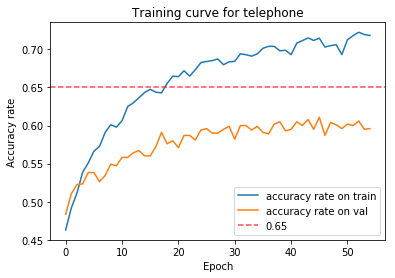

--------------------------------------------
------------------Fine-tuning on slate--------------------------
epoch  0  accuracy on training dataset:  0.4483358171882762  accuracy on val dataset:  0.4351297405189621
epoch  1  accuracy on training dataset:  0.472180824639841  accuracy on val dataset:  0.46506986027944114
epoch  2  accuracy on training dataset:  0.49056135121708894  accuracy on val dataset:  0.46506986027944114
epoch  3  accuracy on training dataset:  0.5042225534028812  accuracy on val dataset:  0.469061876247505
epoch  4  accuracy on training dataset:  0.5243417784401391  accuracy on val dataset:  0.4750499001996008
epoch  5  accuracy on training dataset:  0.5320417287630402  accuracy on val dataset:  0.47904191616766467
epoch  6  accuracy on training dataset:  0.5491803278688525  accuracy on val dataset:  0.49001996007984033
epoch  7  accuracy on training dataset:  0.5638350720317934  accuracy on val dataset:  0.49600798403193613
epoch  8  accuracy on training dataset

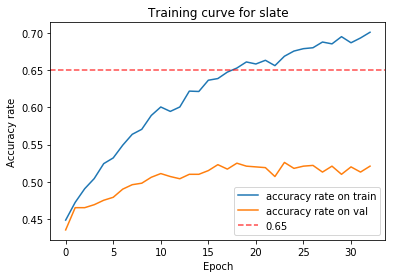

--------------------------------------------
------------------Fine-tuning on travel--------------------------
epoch  0  accuracy on training dataset:  0.47628607277289836  accuracy on val dataset:  0.4786150712830957
epoch  1  accuracy on training dataset:  0.5184441656210791  accuracy on val dataset:  0.5224032586558045
epoch  2  accuracy on training dataset:  0.5435382685069009  accuracy on val dataset:  0.5274949083503055
epoch  3  accuracy on training dataset:  0.5613550815558344  accuracy on val dataset:  0.5386965376782077
epoch  4  accuracy on training dataset:  0.5786700125470514  accuracy on val dataset:  0.5407331975560081
epoch  5  accuracy on training dataset:  0.5912170639899623  accuracy on val dataset:  0.5427698574338086
epoch  6  accuracy on training dataset:  0.605771643663739  accuracy on val dataset:  0.544806517311609
epoch  7  accuracy on training dataset:  0.6180677540777917  accuracy on val dataset:  0.5539714867617108
epoch  8  accuracy on training dataset:  0

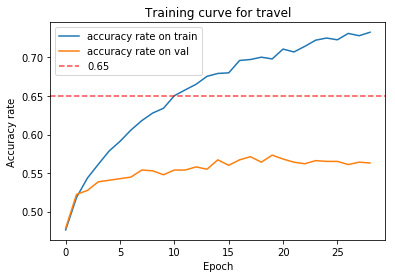

--------------------------------------------
------------------Fine-tuning on government--------------------------
epoch  0  accuracy on training dataset:  0.496008241050734  accuracy on val dataset:  0.4793307086614173
epoch  1  accuracy on training dataset:  0.5271697141385526  accuracy on val dataset:  0.5
epoch  2  accuracy on training dataset:  0.539273757404069  accuracy on val dataset:  0.5167322834645669
epoch  3  accuracy on training dataset:  0.5629667782642287  accuracy on val dataset:  0.5265748031496063
epoch  4  accuracy on training dataset:  0.5732680916816895  accuracy on val dataset:  0.5246062992125984
epoch  5  accuracy on training dataset:  0.5920679886685553  accuracy on val dataset:  0.5413385826771654
epoch  6  accuracy on training dataset:  0.603914499098635  accuracy on val dataset:  0.5413385826771654
epoch  7  accuracy on training dataset:  0.6082925573010559  accuracy on val dataset:  0.5462598425196851
epoch  8  accuracy on training dataset:  0.628637651300

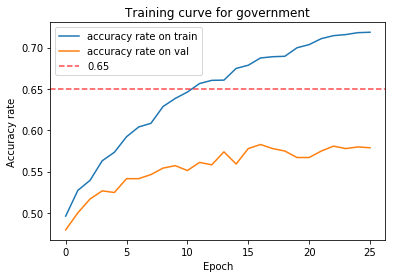

--------------------------------------------
------------------Fine-tuning on fiction--------------------------
epoch  0  accuracy on training dataset:  0.4762773722627737  accuracy on val dataset:  0.4914572864321608
epoch  1  accuracy on training dataset:  0.5041710114702815  accuracy on val dataset:  0.5005025125628141
epoch  2  accuracy on training dataset:  0.5174661105318039  accuracy on val dataset:  0.507537688442211
epoch  3  accuracy on training dataset:  0.5305005213764338  accuracy on val dataset:  0.5095477386934674
epoch  4  accuracy on training dataset:  0.5503128258602711  accuracy on val dataset:  0.5125628140703518
epoch  5  accuracy on training dataset:  0.5641293013555787  accuracy on val dataset:  0.5155778894472361
epoch  6  accuracy on training dataset:  0.5774244004171012  accuracy on val dataset:  0.5266331658291458
epoch  7  accuracy on training dataset:  0.5904588112617309  accuracy on val dataset:  0.528643216080402
epoch  8  accuracy on training dataset:  0

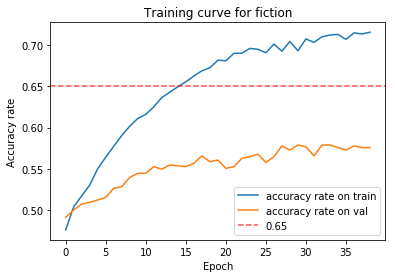

--------------------------------------------


In [36]:
all_record = []
for index in range(len((mnli_val_iter_list))):
    print('------------------Fine-tuning on '+str(GENRE.vocab.itos[index+1])+'--------------------------')
    save_file_name = '../save_model/rnn_'+ GENRE.vocab.itos[index+1]
    model = torch.load('../save_model/Rnn_max')
    model.cuda()
    
    para1_list = []
    para2_list = []
    
    for i,j in model.named_parameters():
        if j.requires_grad:
            if 'linear' in i:
                para1_list.append(j)
            else:
                para2_list.append(j)
    optimizer = torch.optim.Adam([{'params':para1_list, 'lr':0.0001, 'weight_decay':0.01},
                     {'params':para2_list, 'lr':0.0001, 'weight_decay':0.005}])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5)
    
    train_accuracy_list, val_accuracy_list = complete_process(model, mnli_train_iter_list[index], mnli_val_iter_list[index], 
                                                              optimizer, scheduler, save_file_name,early_stopping_rounds=8)
    
    plot_training_curve( train_accuracy_list, val_accuracy_list, GENRE.vocab.itos[index+1])

    all_record.append([GENRE.vocab.itos[index+1], np.argmax(val_accuracy_list), max(val_accuracy_list)])
    print('--------------------------------------------')

In [37]:
all_record

[['telephone', 45, 0.6109452736318408],
 ['slate', 23, 0.5259481037924152],
 ['travel', 19, 0.5733197556008147],
 ['government', 16, 0.5826771653543307],
 ['fiction', 29, 0.578894472361809]]

In [39]:
final_result = []
for i in range(len(mnli_val_iter_list)):
    genre = GENRE.vocab.itos[i+1]
    result = [genre]
    model = torch.load('../save_model/rnn_'+ genre)
    for j in range(len(mnli_val_iter_list)):
        acc = test(model, mnli_val_iter_list[j])
        result.append(acc)
    final_result.append(result)

/Users/qintai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/Users/qintai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


In [75]:
final_result = [['telephone',
  0.6109452736318408,
  0.5219560878243513,
  0.5295315682281059,
  0.5570866141732284,
  0.5597989949748744],
 ['slate',
  0.5373134328358209,
  0.5259481037924152,
  0.5519348268839104,
  0.5679133858267716,
  0.5648241206030151],
 ['travel',
  0.5412935323383085,
  0.530938123752495,
  0.5733197556008147,
  0.5590551181102362,
  0.5366834170854271],
 ['government',
  0.5323383084577115,
  0.49500998003992014,
  0.5356415478615071,
  0.5826771653543307,
  0.5246231155778894],
 ['fiction',
  0.5582089552238806,
  0.5169660678642715,
  0.5366598778004074,
  0.5561023622047244,
  0.578894472361809]]

data = pd.DataFrame(final_result, columns=['the genre where fine-tuning','telephone','slate','travel','government','fiction'])
data = data.set_index('the genre where fine-tuning')
data.columns.name = 'Evaluate on genre'
data

Evaluate on genre,telephone,slate,travel,government,fiction
the genre where fine-tuning,,,,,
telephone,0.610945,0.521956,0.529532,0.557087,0.559799
slate,0.537313,0.525948,0.551935,0.567913,0.564824
travel,0.541294,0.530938,0.573320,0.559055,0.536683
government,0.532338,0.495010,0.535642,0.582677,0.524623
fiction,0.558209,0.516966,0.536660,0.556102,0.578894


In [83]:
previous_result_1 = np.array(previous_result)[np.newaxis,:]

In [89]:
data.iloc[:,:] = data.values - previous_result_1

In [91]:
data.columns.name = 'Accuracy improvement for each genre'

In [92]:
data

Accuracy improvement for each genre,telephone,slate,travel,government,fiction
the genre where fine-tuning,,,,,
telephone,0.127363,0.086826,0.050916,0.077756,0.068342
slate,0.053731,0.090818,0.073320,0.088583,0.073367
travel,0.057711,0.095808,0.094705,0.079724,0.045226
government,0.048756,0.059880,0.057026,0.103346,0.033166
fiction,0.074627,0.081836,0.058045,0.076772,0.087437
